# **PREDICTING SAN FRANCISCO HOUSEPRICES**

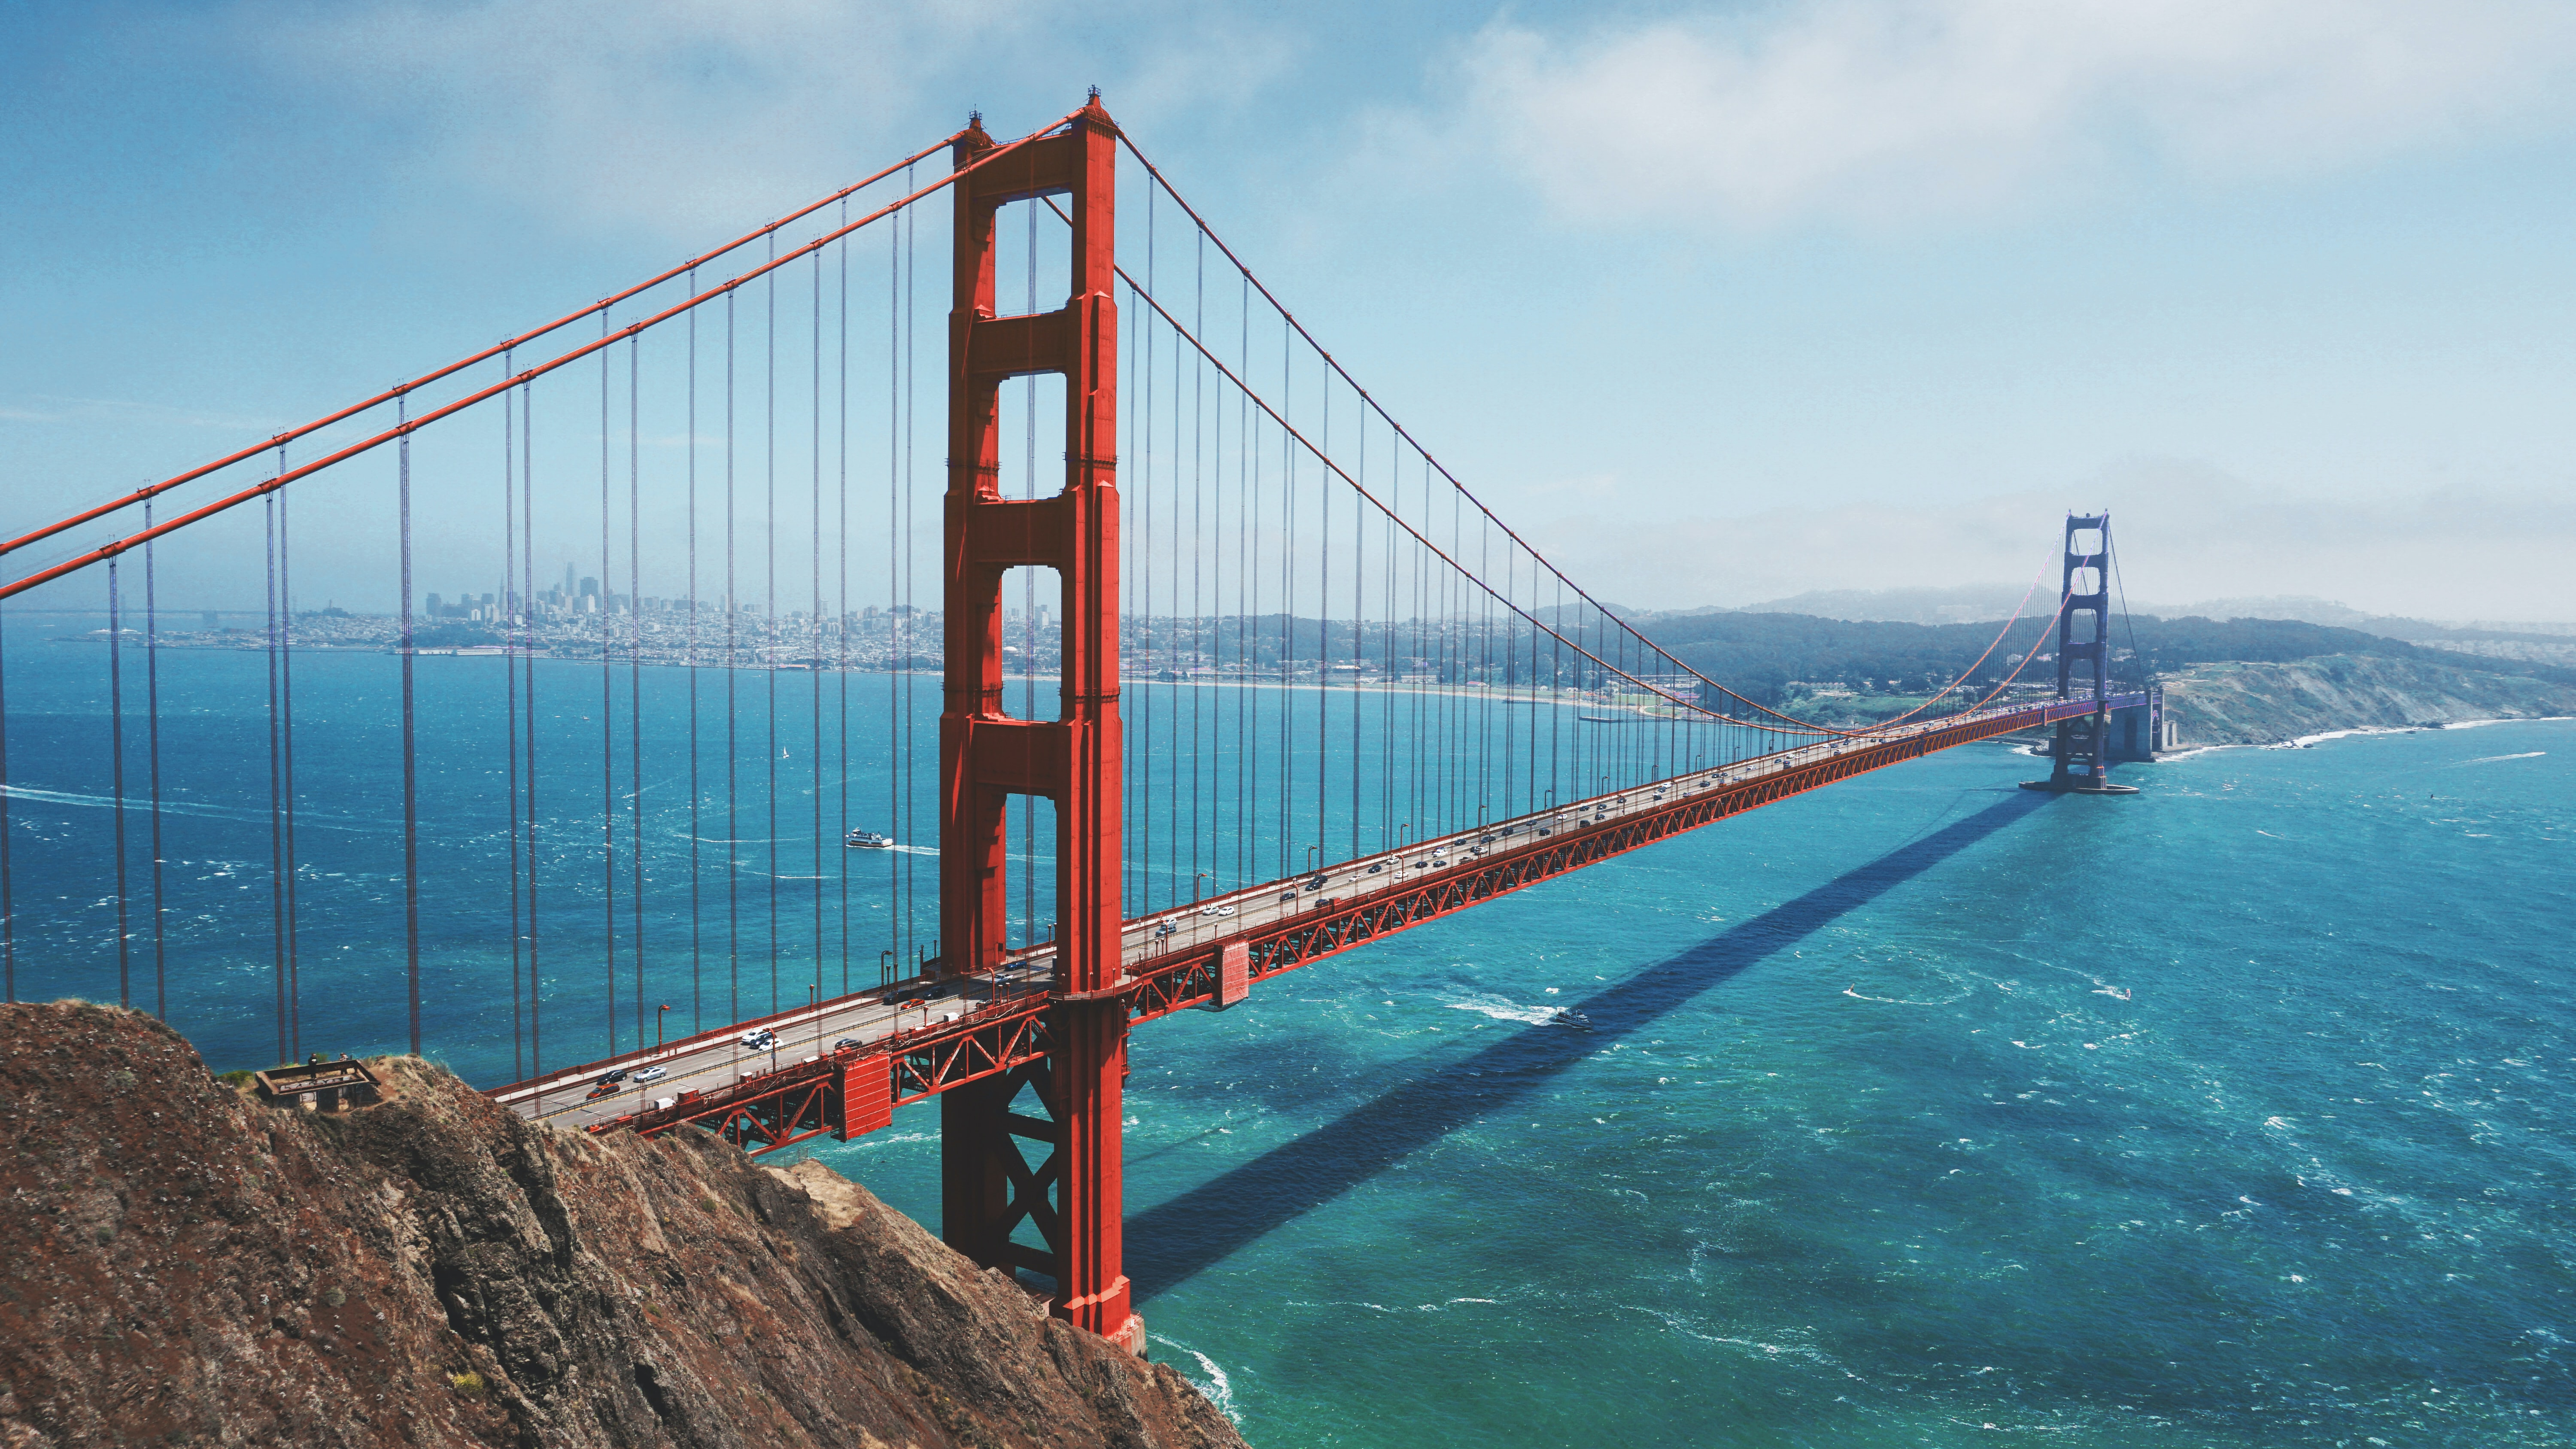

In [ ]:
#@title The foggy city!
from IPython.display import Image
Image(filename='/content/San Francisco Photo.jpg')

# **RESEARCH QUESTION**


*   Can we predict price at which a property will be sold in the current market in San Francisco?






# **DATA COLLECTION**



*   PrpertyExtendedSearch endpoint Zillow API; https://rapidapi.com/apimaker/api/zillow-com1
*   API output is property list with 27 Columns including: 'dateSold', 'propertyType', 'lotAreaValue', 'address', 'zestimate',
       'imgSrc', 'price', 'bedrooms', 'contingentListingType', 'longitude',
       'latitude', 'listingStatus', 'zpid', 'rentZestimate', 'daysOnZillow',
       'bathrooms', 'livingArea'.
*   Google Map's GeoCode API to enhance the data with neighboorhood location for each property: https://developers.google.com/maps/documentation/geocoding/overview







# **DATA CLEANING**


*   Deleted columns containing irrelevant data (i.e. contingentListingType, ListingStatus, currency, Days on Zillow)
*   Deleted rows containing irrelevant data (i.e. properties that are Under_Contract)
*   Cleaned the formatting for some of the rows (i.e. date sold was in UNIX format, converted to datetime format)

# **DATA EXPLORATION**

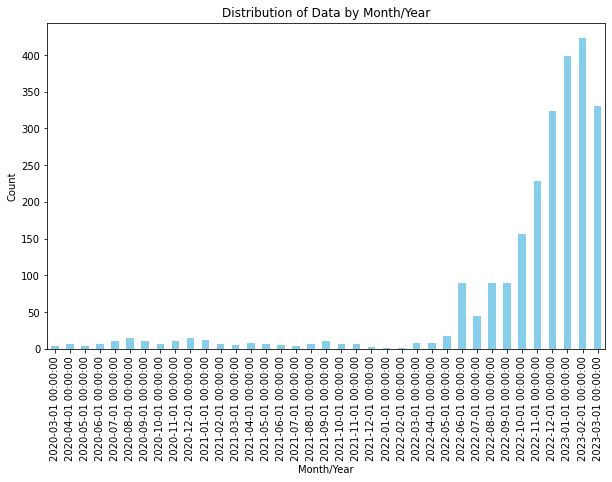

In [ ]:
#@title How is the listing distributed by month and year?
import matplotlib.pyplot as plt

counts = df_sold_listings_All["month_year"].value_counts()
counts.index = pd.to_datetime(counts.index, format="%m/%Y")
counts = counts.sort_index()

ax = counts.plot(kind="bar", figsize=(10, 6), color="skyblue")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Count")
ax.set_title("Distribution of Data by Month/Year")

plt.show()

Looking at the distribution of the data I was able to get from Zillow, there is data mostly for the last 10 months starting from 6/1/2022. Most of the data is from more recent months, so should give a good idea about the recent market condition.

In [ ]:
#@title What is the breakdown among different property types
df_sold_listings_All["propertyType"].value_counts()

SINGLE_FAMILY    1110
TOWNHOUSE         788
CONDO             369
MULTI_FAMILY       82
APARTMENT          15
LOT                10
Name: propertyType, dtype: int64

Removed lots from the property type

In [ ]:
#@title Adding a price per sqft column
#I will add a column called price/sq ft
df_sold_listings_All["price per sqft"] = df_sold_listings_All['price']/df_sold_listings_All["livingArea"]
#Want to see the summary statistics for all the numeric values
df_sold_listings_All.describe()
#price per sqft of inf and mean of inf need more exploring

lotAreaValue     zestimate         price     bedrooms    longitude  \
count   2276.000000  2.084000e+03  2.364000e+03  2236.000000  2282.000000   
mean    2324.654393  1.548272e+06  1.577092e+06     2.829606  -122.430768   
std     2030.668784  1.161674e+06  2.122635e+06     1.144988     0.034552   
min        0.000000  2.935000e+05  2.000000e+03     0.000000  -122.509030   
25%      908.000000  1.009000e+06  9.853220e+05     2.000000  -122.454125   
50%     2350.000000  1.267550e+06  1.260000e+06     3.000000  -122.431786   
75%     2996.928000  1.673500e+06  1.700000e+06     3.000000  -122.402266   
max    14125.000000  2.461100e+07  5.150000e+07    15.000000  -122.368220   

          latitude          zpid  rentZestimate  daysOnZillow    bathrooms  \
count  2282.000000  2.364000e+03    2246.000000        2364.0  2312.000000   
mean     37.748118  2.414823e+08    5809.266251          -1.0     2.298335   
std       0.025674  5.856752e+08    3681.203759           0.0     1.095709   
min      37.708340  1.506388e+07    1719.000000          -1.0     0.000000   
25%      37.729008  1.513424e+07    4194.500000          -1.0     2.000000   
50%      37.743517  1.517893e+07    4935.500000          -1.0     2.000000   
75%      37.764129  1.176722e+08    5994.000000          -1.0     3.000000   
max      37.805750  2.140022e+09   82493.000000          -1.0     9.000000   

         livingArea  price per sqft  
count   2314.000000     2314.000000  
mean    1676.607606             inf  
std     1100.572256             NaN  
min        0.000000        3.142857  
25%     1176.000000      664.048338  
50%     1510.000000      865.176640  
75%     1962.250000     1092.436975  
max    17315.000000             inf



*   Removed rows with price per sqft of NaN
*   Removed price per sqft outliers: one with price per sqft of 38161.237785! and another square feet data was 1.0 (incorrect).



In [ ]:
#@title Stats on updated dataframe
#Ran the stats on the updated dataframe
df_sold_listings_All.describe()

lotAreaValue     zestimate         price     bedrooms    longitude  \
count   2116.000000  1.979000e+03  2.198000e+03  2121.000000  2129.000000   
mean    2279.037638  1.544187e+06  1.539094e+06     2.857614  -122.431462   
std     2019.041636  1.167787e+06  1.280761e+06     1.145335     0.034679   
min        0.000000  2.935000e+05  2.200000e+03     0.000000  -122.509030   
25%      908.000000  1.007450e+06  1.000000e+06     2.000000  -122.455680   
50%     2238.000000  1.259500e+06  1.275000e+06     3.000000  -122.432220   
75%     2996.928000  1.673500e+06  1.700000e+06     3.000000  -122.403220   
max    10856.000000  2.461100e+07  2.950000e+07    15.000000  -122.368350   

          latitude          zpid  rentZestimate    bathrooms    livingArea  \
count  2129.000000  2.198000e+03    2098.000000  2194.000000   2198.000000   
mean     37.748115  2.341728e+08    5866.766444     2.318482   1764.531847   
std       0.025578  5.799846e+08    3718.369975     1.099428   1058.418002   
min      37.708340  1.506388e+07    1719.000000     0.000000    150.000000   
25%      37.729008  1.513357e+07    4273.000000     2.000000   1217.500000   
50%      37.743877  1.517679e+07    4963.000000     2.000000   1527.000000   
75%      37.763830  1.119336e+08    5994.000000     3.000000   2002.000000   
max      37.805750  2.140022e+09   82493.000000     9.000000  17315.000000   

       price per sqft  
count     2198.000000  
mean       879.114254  
std        373.167297  
min          3.142857  
25%        661.764706  
50%        848.785182  
75%       1046.646756  
max       7800.000000

Average price of property sold in the last 10 months is 1.5M, average price per square feet is $879.

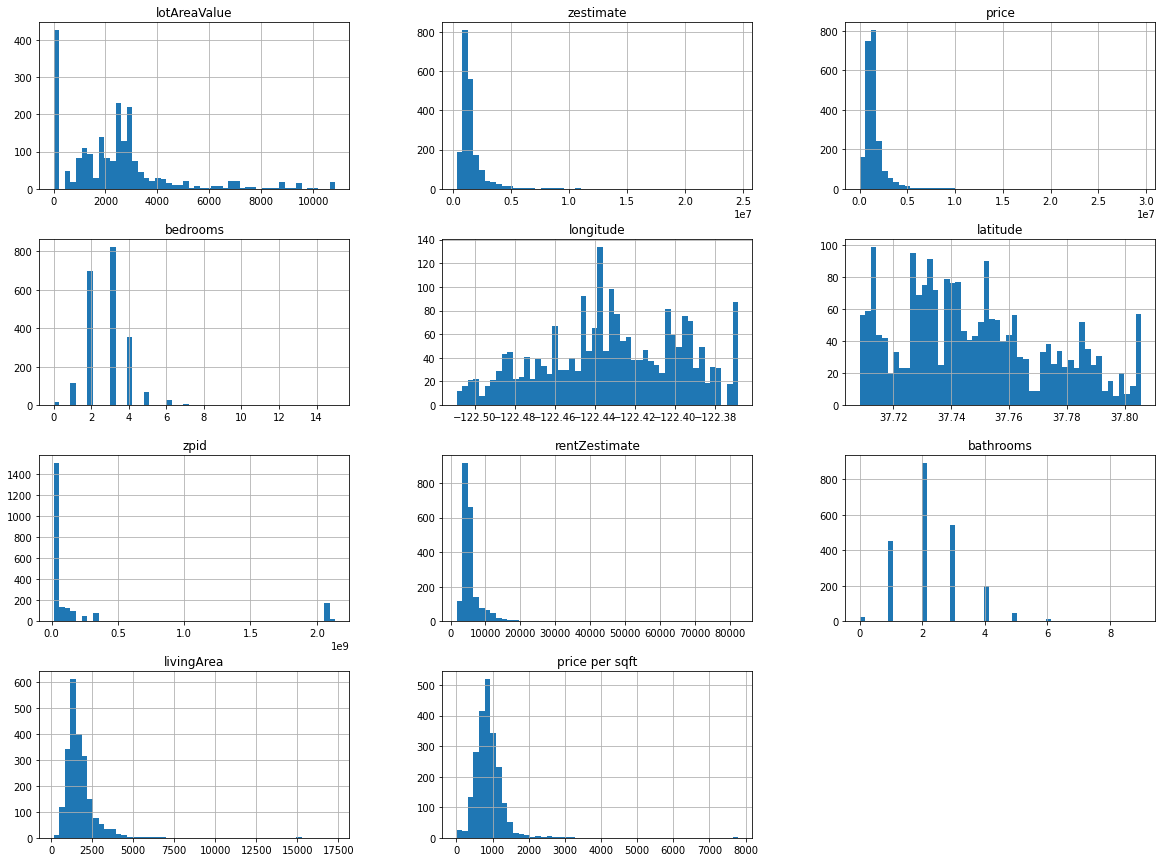

In [ ]:
#@title Distribution of all the quantitative variables
#plot each numeric variable to see its distribution
%matplotlib inline
import matplotlib.pyplot as plt
df_sold_listings_All.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

<Axes: xlabel='longitude', ylabel='latitude'>

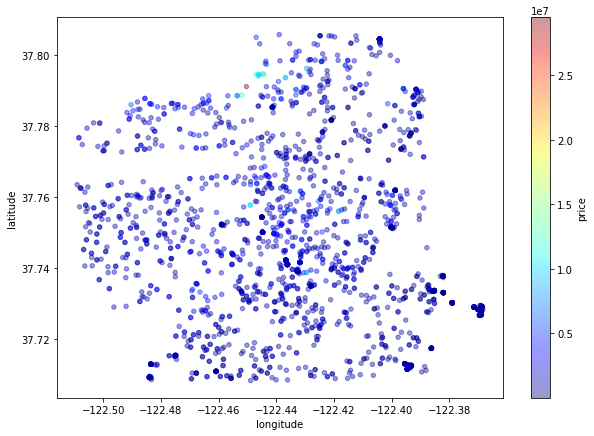

In [ ]:
#@title Mapping the properties and color coding price
#Add color coding based on price
df_sold_listings_All.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

From the above scatterplot, the most expensive properties were sold in the north part of SF. Let's find out exactly what neighborhoods.

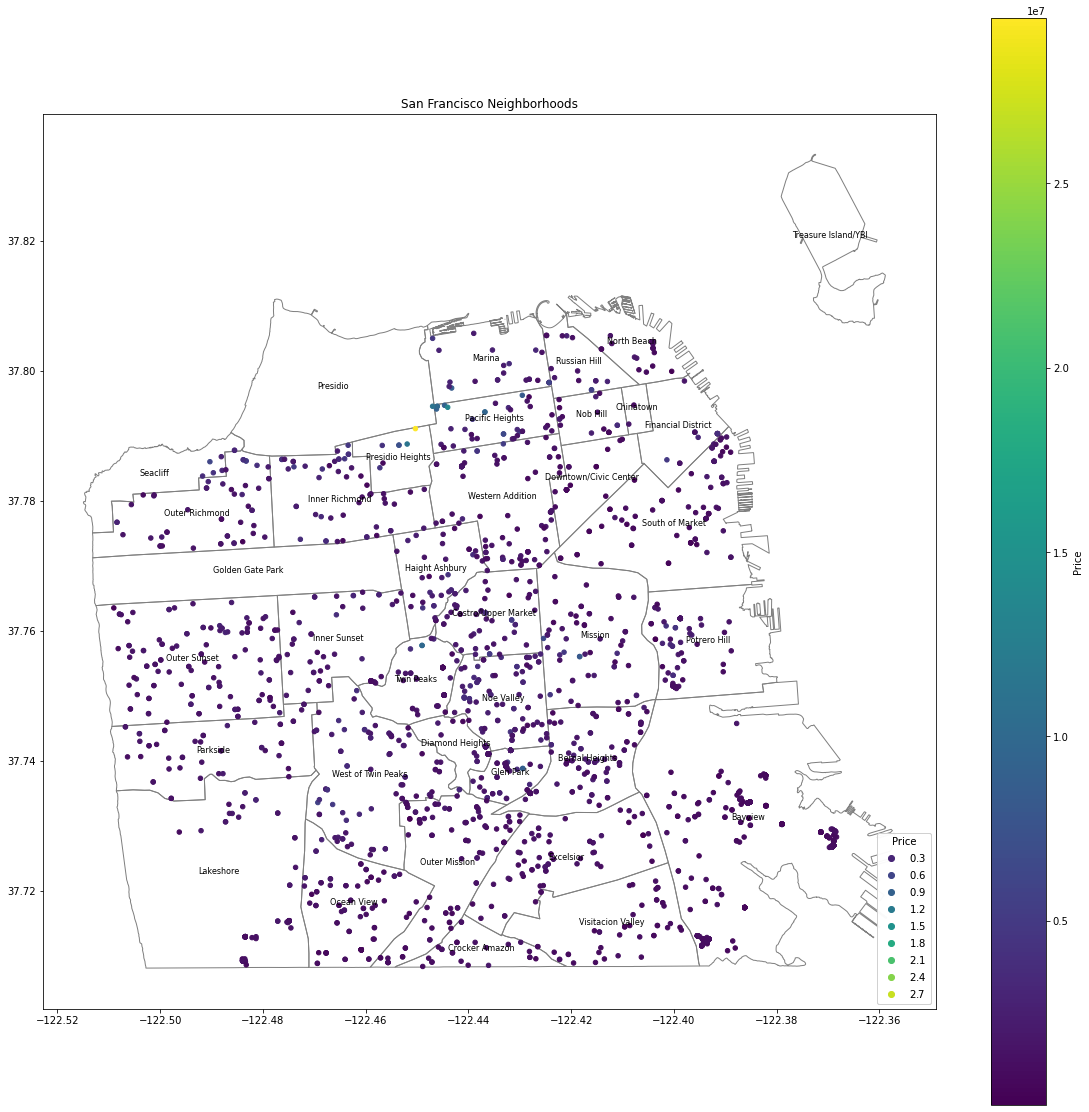

In [ ]:
#@title Property breakdown per neighborhood
from IPython.display import Image
Image(filename='/content/download.png')


*   Shapefile source: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63
*   Most expensive properties were sold in Presidio Heights, and Pacific Heights.

In [ ]:
#@title Relationship between the price and other quantitative variables
#Looking at relationship of variables to price
corr_matrix = df_sold_listings_All.corr()
corr_matrix["price"].sort_values(ascending=False)

price             1.000000
zestimate         0.983689
rentZestimate     0.892541
livingArea        0.672925
price per sqft    0.523621
bathrooms         0.474447
bedrooms          0.377848
latitude          0.272094
lotAreaValue      0.215020
zpid             -0.068253
longitude        -0.198513
Name: price, dtype: float64

The price has a high positive corrolation with livingArea (as expected, bigger homes sell for more), there is also a positive corrolation between price and # of bedroom and # of bathrooms. There is a negative corrolation between the longitude and price (maybe houses that are further away from the center of the city are less desirable or smaller).

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


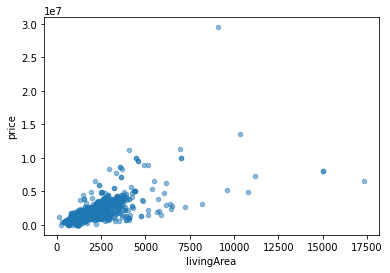

In [ ]:
#@title LivingArea vs. Price scatterplot
df_sold_listings_All.plot(kind="scatter", x="livingArea", y="price", alpha=0.5)
plt.savefig('scatter.png')

Confirming the strong corrolation between livingArea and Price, some outliers that I remove for Machine Learning.

# **MACHINE LEARNING**

Trying to predict price, a quantitative variable, so I used 3 regression models:

*   Knearest Neighbors
*   Linear Regression
*   Random Forest Regression

Features: propertyType, bedrooms, bathrooms, livingArea

**Knearest Neighbors:**
*   The best RMSE was 636671.990210, using 7 nearest neighbors.
*   Input features : bedrooms, livingArea

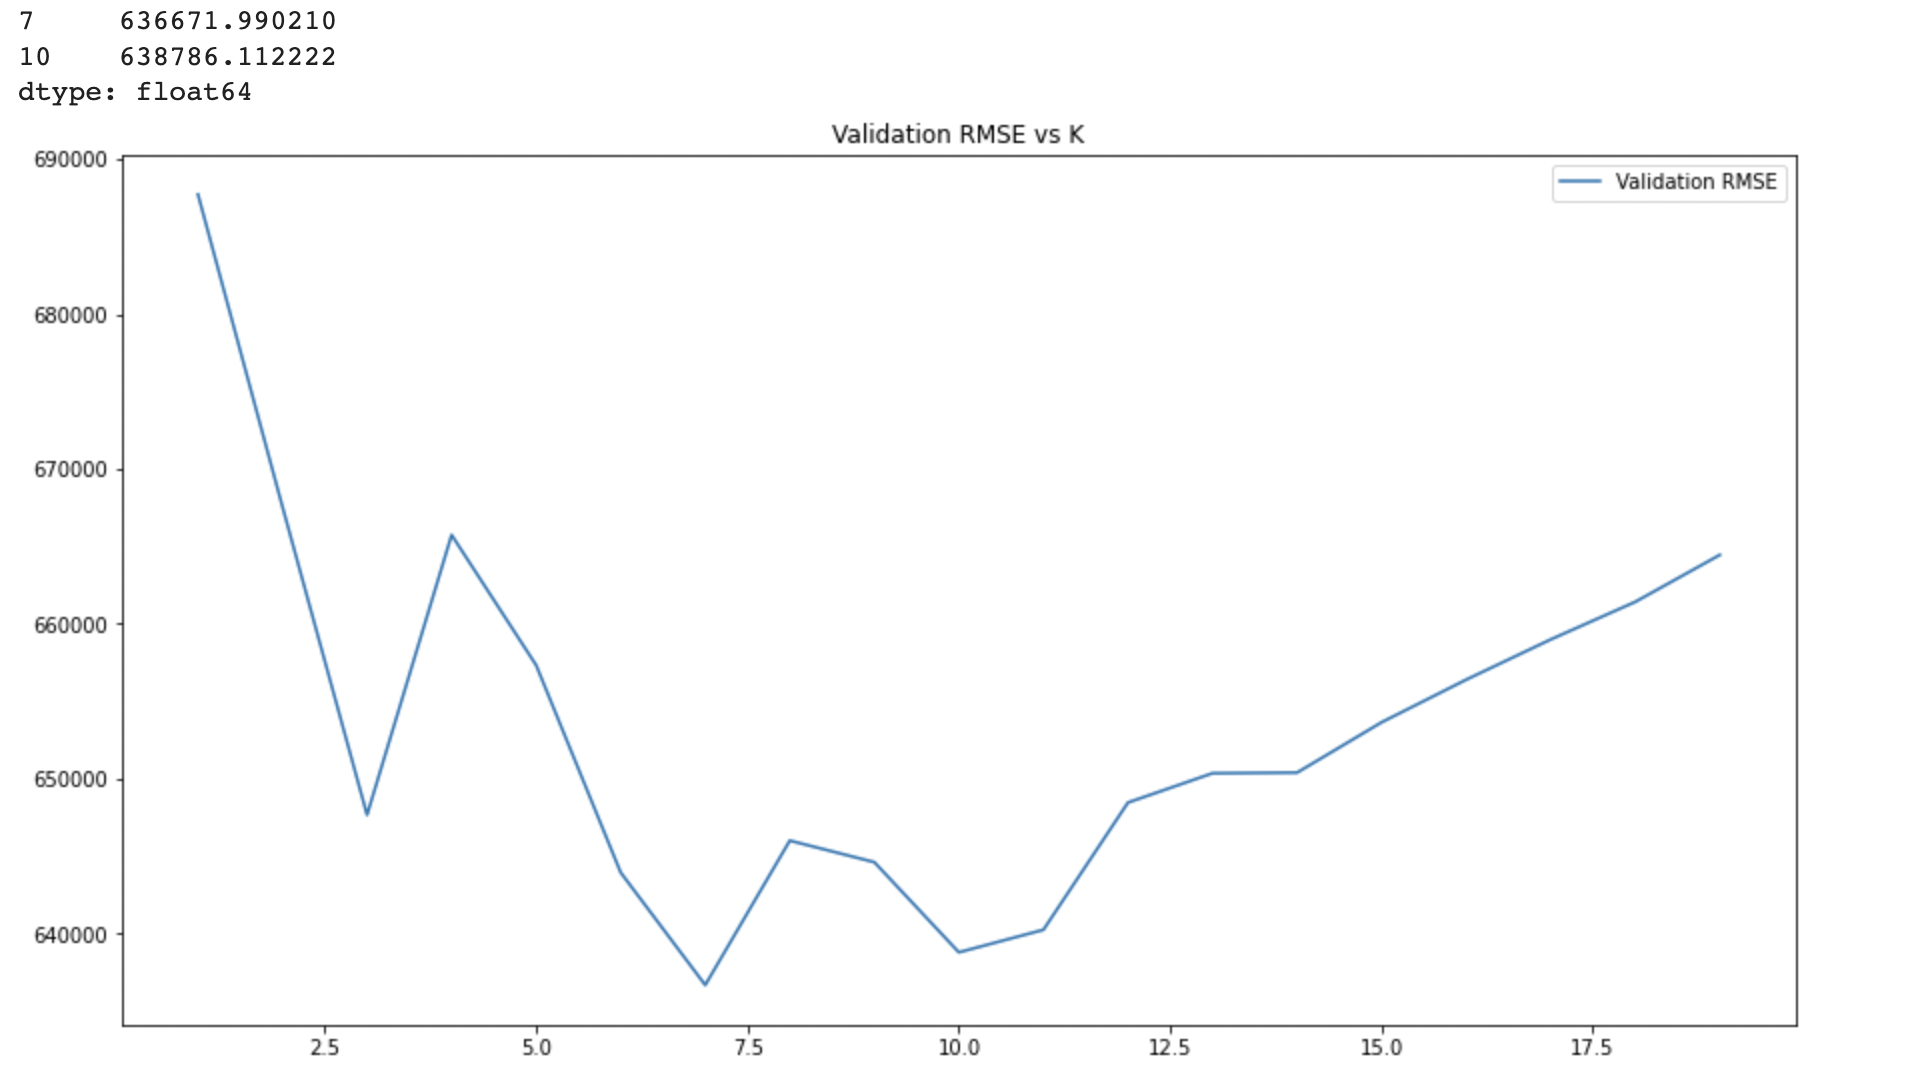

In [ ]:
#@title K-nearest RMSE
from IPython.display import Image
Image(filename='/content/KNearest.png')



**Linear Regression:**
*   The best RMSE was 6.58e+05
*  Input features: bedrooms, bathrooms, livingArea             



**Random Forrest Regression:**
*   The best RMSE was 5.70e+05
*  Input features: livingArea, bedrooms

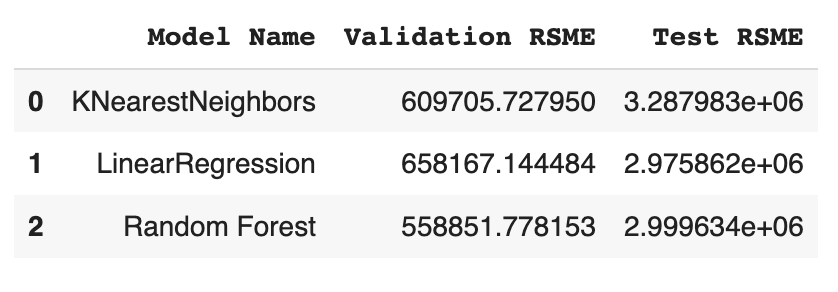

In [ ]:
#@title Running the model on test data
Image(filename='/content/Testing Data.png')